# [$\alpha$/Fe] vs [Fe/H] throughout the Galaxy

This notebook is where you will generate the central plot of this project: the alpha-element-to-iron abundance ratio against metallicity for different regions of the Milky Way.

## Setup

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for the random sampling function
from numpy.random import default_rng
# for coordinate conversions
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic, Galactocentric
from matplotlib.colors import LogNorm

In [2]:
# matplotlib settings
plt.rcParams.update({
    'xtick.direction': 'in',  # set ticks pointing in
    'ytick.direction': 'in',
    'xtick.top': True,        # add ticks to top and right edges
    'ytick.right': True,
    'figure.dpi': 300,    # high resolution for poster
    'axes.labelsize': 15,
    'axes.titlesize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})

In the cell below, use the `pd.read_csv()` function to import the APOGEE data into a DataFrame named `full_df`. Refer back to previous notebooks if you're unsure.

In [3]:
full_df = pd.read_csv('APOGEEdata.csv')

### Sample Selection

In [4]:
# Limit to main survey targets
sample_df = full_df[full_df['EXTRATARG'] == 0]
# Remove all stars flagged as bad
sample_df = sample_df[sample_df['ASPCAPFLAG'] & (2**23) == 0]
# Replace NaN stand-in values with NaN
sample_df.replace(99.999, np.nan, inplace=True)

In the blank cell below, limit the contents of `sample_df` to stars with signal-to-noise ratio greater than 80, srface gravity $\log(g)$ between 1.0 and 3.8, and temperature $T_{\rm{eff}}$ between 3500 K and 5500 K. Refer back to the `ExploringAPOGEE.ipynb` notebook if you're unsure.

In [5]:
sample_df = sample_df[(sample_df['LOGG'] > 1.0) & (sample_df['LOGG'] < 3.8) & (sample_df['TEFF'] > 3500) & (sample_df['TEFF'] < 5500) & (sample_df['SNREV'] > 80)]

Print the sample DataFrame as a sanity check: there should be roughly 192,000 stars.

In [6]:
# reset the DataFrame index to sequential integers
sample_df.reset_index(inplace=True, drop=True)
# print the sample as a sanity check
sample_df

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,0.011601,0,NaN,NaN,0.004401,2,-0.055580,0.000080,0.086572,0
1,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,0.022662,0,NaN,NaN,0.025131,2,-0.256490,-0.200830,0.132389,0
2,2M00000211+6327470,apo25m,117+01,none,0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,0.012733,0,NaN,NaN,NaN,259,0.194041,0.249701,0.070006,0
3,2M00000222+5625359,apo25m,N7789,none,0.009287,56.426662,115.831519,-5.734687,11.982,0.023,...,0.017069,0,NaN,NaN,0.007840,2,-0.356350,-0.300690,0.131302,0
4,2M00000446+5854329,apo25m,116-04,none,0.018603,58.909149,116.330761,-3.302585,12.255,0.023,...,0.014729,0,NaN,NaN,NaN,259,0.208779,0.264439,0.087975,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192921,2M23595669+6131251,apo25m,116+00,none,359.986225,61.523659,116.833497,-0.736743,11.698,0.026,...,0.017598,0,NaN,NaN,0.014083,2,-0.017480,0.038180,0.112270,0
192922,2M23595676+7918072,apo25m,120+18,none,359.986523,79.302002,120.457508,16.678604,9.848,0.026,...,0.013729,0,NaN,NaN,NaN,259,-0.193610,-0.137950,0.043006,0
192923,2M23595837+5700444,apo25m,N7789,none,359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,0.022493,0,NaN,NaN,0.016774,2,-0.035640,0.020020,0.141408,0
192924,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0.011980,0,NaN,NaN,NaN,259,-0.058750,-0.003090,0.072443,0


### Galactocentric coordinates

In [7]:
def galactic_to_galactocentric(l, b, distance):
    r"""
    Use astropy's SkyCoord to convert Galactic (l, b, distance) coordinates
    to galactocentric (r, phi, z) coordinates.

    Parameters
    ----------
    l : array-like
        Galactic longitude in degrees
    b : array-like
        Galactic latitude in degrees
    distance : array-like
        Distance (from Sun) in parsecs

    Returns
    -------
    galr : numpy array
        Galactocentric radius in kpc
    galphi : numpy array
        Galactocentric phi-coordinates in degrees
    galz : numpy array
        Galactocentric z-height in kpc
    """
    l = np.array(l)
    b = np.array(b)
    d = np.array(distance)
    if l.shape == b.shape == d.shape:
        if not isinstance(l, u.quantity.Quantity):
            l *= u.deg
        if not isinstance(b, u.quantity.Quantity):
            b *= u.deg
        if not isinstance(d, u.quantity.Quantity):
            d *= u.pc
        galactic = SkyCoord(l=l, b=b, distance=d, frame=Galactic())
        galactocentric = galactic.transform_to(frame=Galactocentric())
        galactocentric.representation_type = 'cylindrical'
        galr = galactocentric.rho.to(u.kpc).value
        galphi = galactocentric.phi.to(u.deg).value
        galz = galactocentric.z.to(u.kpc).value
        return galr, galphi, galz
    else:
        raise ValueError('Arrays must be of same length.')

Using the function above, generate three lists of galactocentric radius ($R_{\rm{Gal}}$), azimuth ($\phi$), and distance from the midplane ($z$). You'll need to pass three columns from the sample DataFrame as inputs: "GLON", "GLAT", and "GAIAEDR3_R_MED_PHOTOGEO". Then, create three new columns in the DataFrame titled "GALR", "GALPHI", and "GALZ" for each of the new lists. Refer back to `PlottingAbundances.ipynb` if you're unsure.

In [8]:
galr_list, galphi_list, galz_list = galactic_to_galactocentric(sample_df['GLON'], sample_df['GLAT'], sample_df['GAIAEDR3_R_MED_PHOTOGEO'])
sample_df['GALR'] = galr_list
sample_df['GALPHI'] = galphi_list
sample_df['GALZ'] = galz_list
sample_df

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,GALR,GALPHI,GALZ
0,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,0.004401,2,-0.055580,0.000080,0.086572,0,8.635928,175.747701,-0.034333
1,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,0.025131,2,-0.256490,-0.200830,0.132389,0,12.113929,154.029010,-0.462842
2,2M00000211+6327470,apo25m,117+01,none,0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,NaN,NaN,259,0.194041,0.249701,0.070006,0,13.014739,151.771833,0.177748
3,2M00000222+5625359,apo25m,N7789,none,0.009287,56.426662,115.831519,-5.734687,11.982,0.023,...,NaN,0.007840,2,-0.356350,-0.300690,0.131302,0,9.392124,168.531880,-0.178405
4,2M00000446+5854329,apo25m,116-04,none,0.018603,58.909149,116.330761,-3.302585,12.255,0.023,...,NaN,NaN,259,0.208779,0.264439,0.087975,0,10.672942,160.520843,-0.196415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192921,2M23595669+6131251,apo25m,116+00,none,359.986225,61.523659,116.833497,-0.736743,11.698,0.026,...,NaN,0.014083,2,-0.017480,0.038180,0.112270,0,10.110304,163.934410,-0.008714
192922,2M23595676+7918072,apo25m,120+18,none,359.986523,79.302002,120.457508,16.678604,9.848,0.026,...,NaN,NaN,259,-0.193610,-0.137950,0.043006,0,9.589135,168.696058,0.683887
192923,2M23595837+5700444,apo25m,N7789,none,359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,NaN,0.016774,2,-0.035640,0.020020,0.141408,0,10.860838,159.358258,-0.351337
192924,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,259,-0.058750,-0.003090,0.072443,0,9.502076,167.743580,-0.156124


### Other useful functions

Below is a function to randomly sample N rows from a DataFrame. This might be useful if you want to make a scatterplot of stars from APOGEE without cluttering the plot with hundreds of thousands of points.

In [9]:
def sample_dataframe(df, n, weights=None, reset=True):
    """
    Randomly sample n unique rows from a pandas DataFrame.

    Parameters
    ----------
    df : pandas DataFrame
    n : int
        Number of random samples to draw
    weights : array, optional
        Probability weights of the given DataFrame
    reset : bool, optional
        If True, reset sample DataFrame index

    Returns
    -------
    pandas DataFrame
        Re-indexed DataFrame of n sampled rows
    """
    if isinstance(df, pd.DataFrame):
        # Initialize default numpy random number generator
        rng = default_rng()
        # Randomly sample without replacement
        rand_indices = rng.choice(df.index, size=n, replace=False, p=weights)
        sample = df.loc[rand_indices]
        if reset:
            sample.reset_index(inplace=True, drop=True)
        return sample
    else:
        raise TypeError('Expected pandas DataFrame.')

## Make the plot

The goal of this plot is to illustrate how the distribution of [$\alpha$/Fe] vs [Fe/H] in stars changes with respect to location in the Galaxy. There are many ways to do this, and the choice often comes down to factors like clarity, aesthetics, and personal preference. Here are a couple options, but feel free to experiment and let me know if you want to try a different route. You only need to pick one.

### Scatter plots

- Make three subplots representing different radial zones: 2-6 kpc, 6-10 kpc, and 10-14 kpc. 
- In each zone, make a scatter plot of [$\alpha$/M] vs [Fe/H] and color-code the points by their _absolute_ distance from the midplane $|z|$. 
- It would be a good idea to limit your sample to only stars with $0\leq |z| < 2$ kpc. 
- You'll also want to use `sample_dataframe()` from above to plot only a small number of all stars in each panel (start with 1000 and try different numbers until it looks good). 
- Make sure to include a colorbar, and use `ax.set_title()` to label each panel with the range of radii.

### 2D histograms

- Make a 2-by-3 grid of subplots where the columns represent different radial zones (2-6 kpc, 6-10 kpc, and 10-14 kpc), and the rows represent different bins in $|z|$ (0-0.5 kpc and 0.5-2 kpc). 
- In each subplot, plot a 2D histogram of the number of stars in [$\alpha$/M] vs [Fe/H] space. 
- You'll need to set the plot range using the keyword argument `range=[[<xmin>, <xmax>], [<ymin>, <ymax>]]` (here I'm using angle brackets <> to represent numbers you'll need to change). 
- Also adjust the number of bins using `bins=(<xbins>, <ybins>)`: pick numbers that make the bins look more or less square, with enough resolution to make out some of the finer details. 
- Label each panel with the region of the galaxy that it represents - you can try using `ax.text()`, `ax.set_title()`, `ax.set_ylabel()`, or some combination of those to make the labels clear.

### Other notes

- You'll want to adjust the size of the figure using the `figsize=(<width in inches>, <height in inches>)` keyword argument in `plt.subplots()`. Choose a size that keeps the font size fairly large and make it wider than it is tall.
- Check out the [matplotlib page on colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) (you can set the colormap using the `cmap='<name>'` keyword argument). 
- Also see [the page for ax.text()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html) for how to put text in your subplots. 

As always, let me know if you have any questions or if any difficulties arise. Happy plotting!

In [10]:
sample_area_1 = sample_df[(sample_df['GALR'] > 2) & (sample_df['GALR'] < 6) & (np.abs(sample_df['GALZ']>0)) & (np.abs(sample_df['GALZ']<2))]
sample_area_2 = sample_df[(sample_df['GALR'] > 6) & (sample_df['GALR'] < 10) & (np.abs(sample_df['GALZ']>0)) & (np.abs(sample_df['GALZ']<2))]
sample_area_3 = sample_df[(sample_df['GALR'] > 10) & (sample_df['GALR'] < 14) & (np.abs(sample_df['GALZ']>0)) & (np.abs(sample_df['GALZ']<2))]
sample_area_4 = sample_df[(sample_df['GALR'] > 2) & (sample_df['GALR'] < 6) & (np.abs(sample_df['GALZ']>0)) & (np.abs(sample_df['GALZ']<.5))]
sample_area_5 = sample_df[(sample_df['GALR'] > 6) & (sample_df['GALR'] < 10) & (np.abs(sample_df['GALZ']>0)) & (np.abs(sample_df['GALZ']<.5))]
sample_area_6 = sample_df[(sample_df['GALR'] > 10) & (sample_df['GALR'] < 14) & (np.abs(sample_df['GALZ']>0)) & (np.abs(sample_df['GALZ']<.5))]
sample_area_7 = sample_df[(sample_df['GALR'] > 2) & (sample_df['GALR'] < 6) & (np.abs(sample_df['GALZ']>.5)) & (np.abs(sample_df['GALZ']<2))]
sample_area_8 = sample_df[(sample_df['GALR'] > 6) & (sample_df['GALR'] < 10) & (np.abs(sample_df['GALZ']>.5)) & (np.abs(sample_df['GALZ']<2))]
sample_area_9 = sample_df[(sample_df['GALR'] > 10) & (sample_df['GALR'] < 14) & (np.abs(sample_df['GALZ']>0.5)) & (np.abs(sample_df['GALZ']<2))]

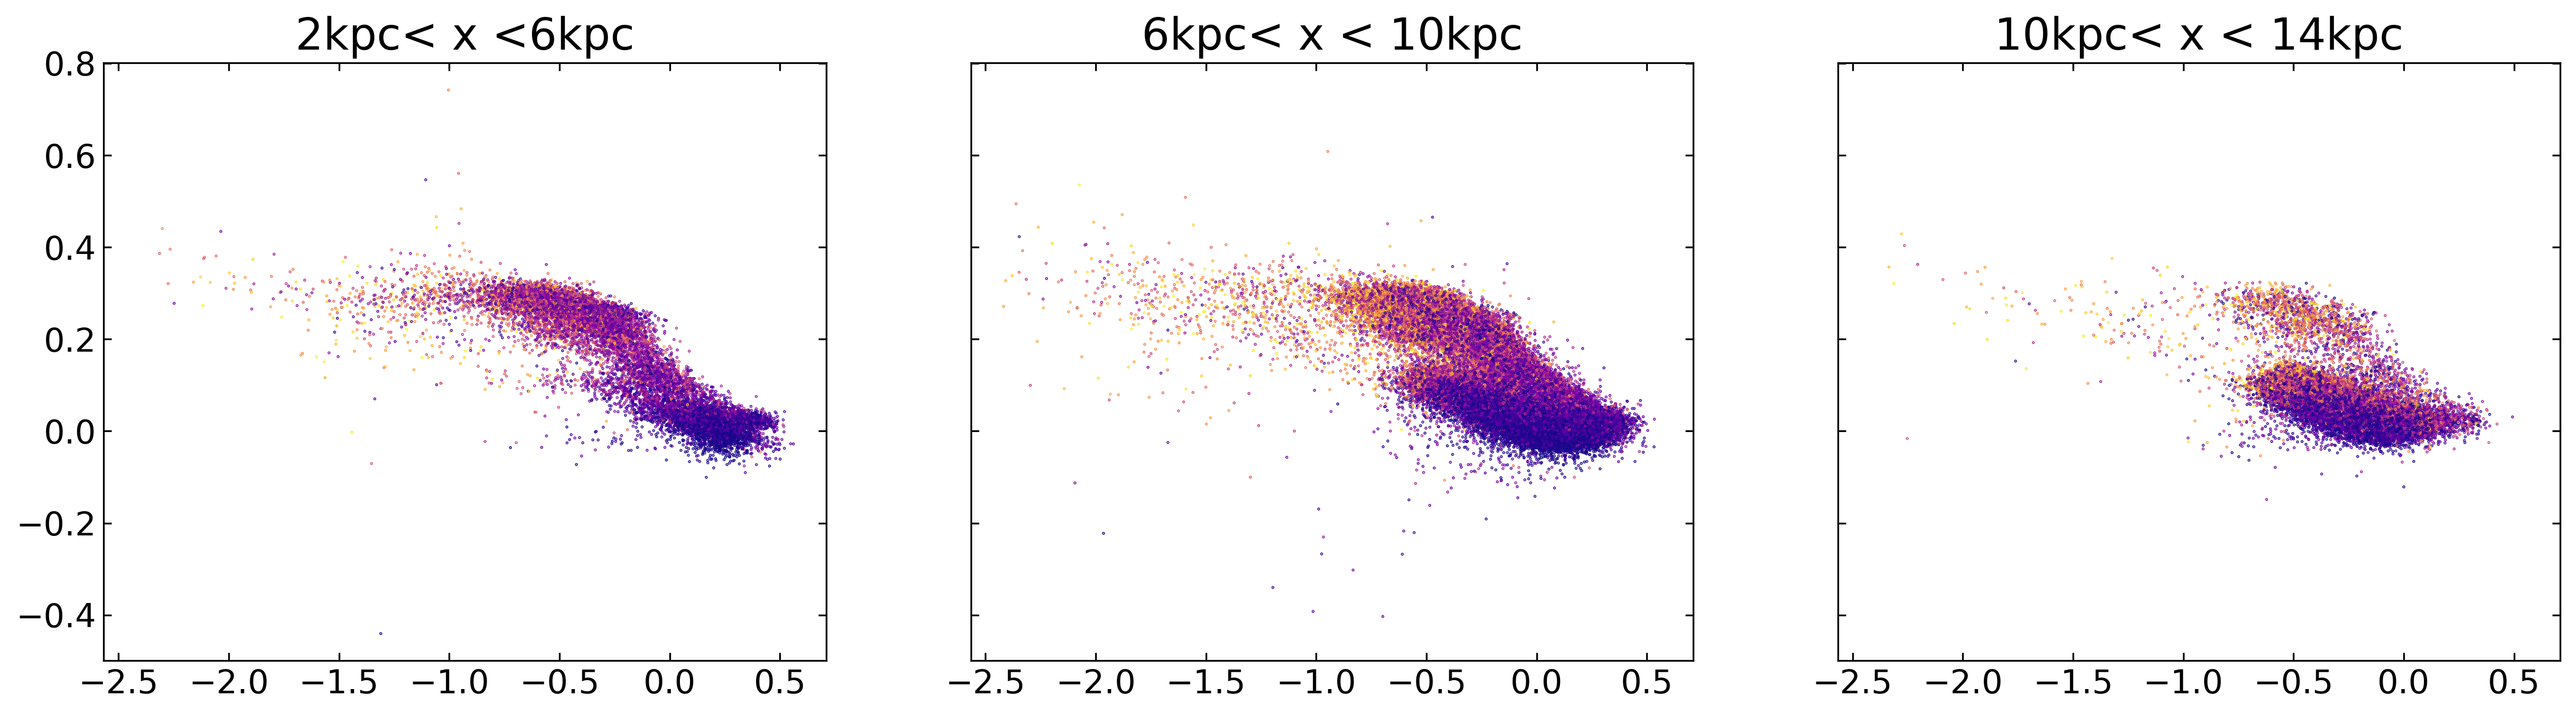

In [11]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(20, 5)) # (rows, column)
axs[0].scatter(sample_area_1['FE_H'], sample_area_1['ALPHA_M'], s=.1, c= sample_area_1['GALZ'], cmap = 'plasma')
axs[0].set_title('2kpc< x <6kpc')
axs[1].scatter(sample_area_2['FE_H'], sample_area_2['ALPHA_M'], s=.1, c= sample_area_2['GALZ'], cmap = 'plasma')
axs[1].set_title('6kpc< x < 10kpc')
axs[2].scatter(sample_area_3['FE_H'], sample_area_3['ALPHA_M'], s=.1, c= sample_area_3['GALZ'], cmap = 'plasma')
axs[2].set_title('10kpc< x < 14kpc')
plt.show()

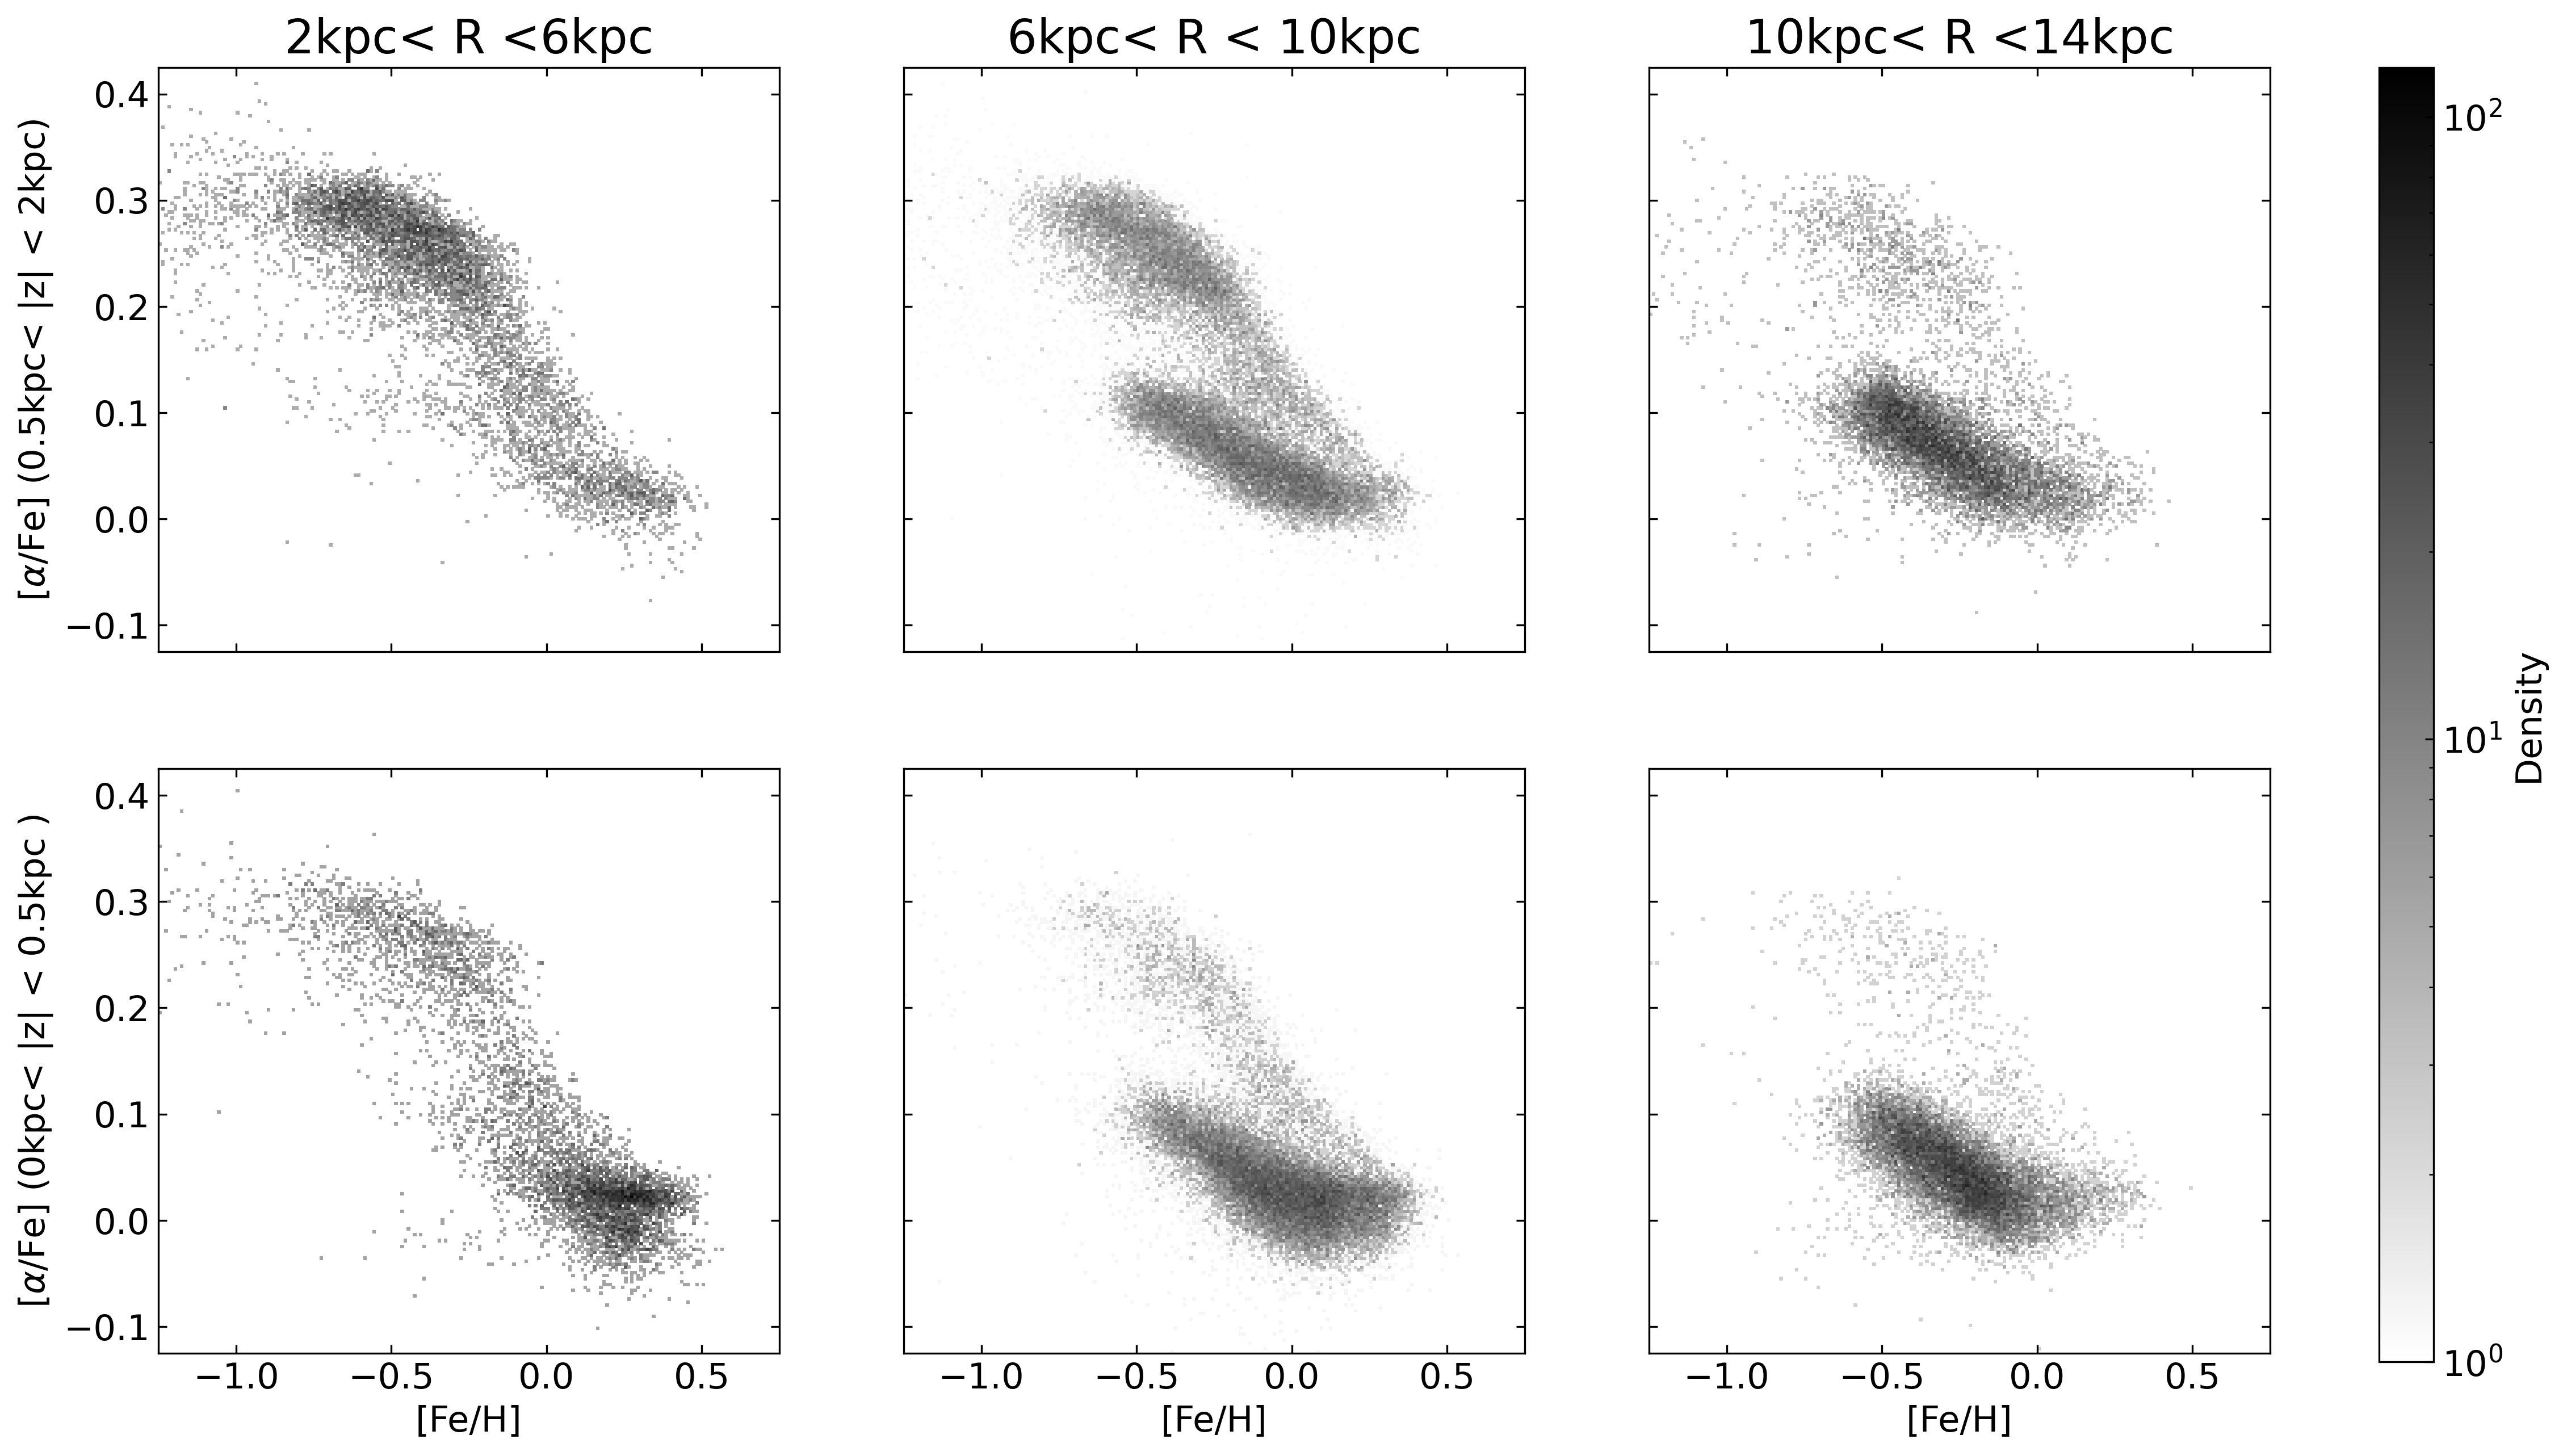

In [30]:
# same normalization across all panels
norm = LogNorm(vmin=1, vmax=120)
cmap = 'binary'
rng = [[-1.25,.75], [-.125,.425]]
bins= 200
fig, axs = plt.subplots(2, 3, sharex = True, sharey = True, figsize= (16,10) ) # (rows, column)
axs[1,0].set_ylabel(r'[$\alpha$/Fe] (0kpc< |z| < 0.5kpc )')
axs[1,0].set_xlabel('[Fe/H]')
axs[1,1].set_xlabel('[Fe/H]')
axs[1,2].set_xlabel('[Fe/H]')
axs[0,0].set_title('2kpc< R <6kpc')
axs[0,1].set_title('6kpc< R < 10kpc')
axs[0,2].set_title('10kpc< R <14kpc')
axs[1,0].hist2d(sample_area_4['FE_H'], sample_area_4['ALPHA_M'], bins = bins, range= rng, cmap = cmap, density = True, norm = norm)
axs[1,1].hist2d(sample_area_5['FE_H'], sample_area_5['ALPHA_M'], bins = bins, range= rng, cmap = cmap, density = True, norm = norm)
axs[1,2].hist2d(sample_area_6['FE_H'], sample_area_6['ALPHA_M'], bins = bins, range= rng, cmap = cmap, density = True, norm = norm)
axs[0,0].set_ylabel(r'[$\alpha$/Fe] (0.5kpc< |z| < 2kpc)')
axs[0,0].hist2d(sample_area_7['FE_H'], sample_area_7['ALPHA_M'], bins = bins, range= rng, cmap = cmap, density = True, norm = norm)
axs[0,1].hist2d(sample_area_8['FE_H'], sample_area_8['ALPHA_M'], bins = bins, range= rng, cmap = cmap, density = True, norm = norm)
h, xedges, yedges, img = axs[0,2].hist2d(sample_area_9['FE_H'], sample_area_9['ALPHA_M'], bins = bins, range= rng, cmap = cmap, density = True, norm = norm)
# add colorbar
plt.subplots_adjust(right=0.9)
cax = plt.axes([0.94, 0.12, 0.02, 0.76])
cbar = fig.colorbar(img, cax, label='Density')
cbar.set_label('Density')
plt.savefig('Stellar Abundances.png', dpi = 300)
plt.show()